In [1]:
!pip install -q scanpy
!pip install -q leidenalg
!pip install -q louvain

     |████████████████████████████████| 2.0 MB 4.7 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 91 kB 9.6 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.2 MB 26.3 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import umap
from anndata import AnnData
from matplotlib.pyplot import rc_context

In [3]:
np.set_printoptions(threshold=np.inf)

In [ ]:
#Location of data, data can be found at https://www-ncbi-nlm-nih-gov.ezproxy.u-pec.fr/geo/query/acc.cgi?acc=GSE111014
#Code runs-as-is, relevant details are in the report.
os.chdir("/content/drive/MyDrive/tcell_exhaustion")

In [5]:
cll_anndata = sc.read_10x_mtx("data/", prefix='GSE111014_')


In [6]:
#cll_anndata = AnnData.concatenate(
#  LN2641,
#  LN4177,
#  LN4521,
#  LN5209,
#  LN5586,
#  PB2642,   
#  PB4174,
#  PB4522,
#  PB5208,
#  PB5585
#)

In [7]:
sc.pp.filter_genes(cll_anndata, min_cells=round(cll_anndata.n_obs * .01))
sc.pp.filter_genes(cll_anndata, min_counts=.5)
sc.pp.filter_cells(cll_anndata, min_genes=30)
sc.pp.filter_cells(cll_anndata, min_counts=0)
sc.pp.log1p(cll_anndata)

In [8]:
tcell_cll_anndata = cll_anndata[np.logical_or(cll_anndata[:, 'CD4'].X.toarray() > 0.001, cll_anndata[:, 'CD8A'].X.toarray() > 0.001), :]

In [9]:
sc.pp.highly_variable_genes(tcell_cll_anndata, n_top_genes = 4096)

Trying to set attribute `._uns` of view, copying.


In [10]:
print(tcell_cll_anndata)

AnnData object with n_obs × n_vars = 5232 × 8353
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [11]:
genes = np.array(cll_anndata.var_names).astype('str')
genes[np.char.find(genes, "2B4") >=0]

sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

sc.pp.neighbors(tcell_cll_anndata)
sc.tl.pca( tcell_cll_anndata)
sc.tl.umap(tcell_cll_anndata)


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==1.0.1 statsmodels==0.10.2 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5
         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [12]:
#Helper call to find genes by substring
genes[np.char.find(genes, "IZU") >=0]

array(['IZUMO4'], dtype='<U18')

In [13]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.louvain(tcell_cll_anndata, key_added='clusters', resolution=.23)
    

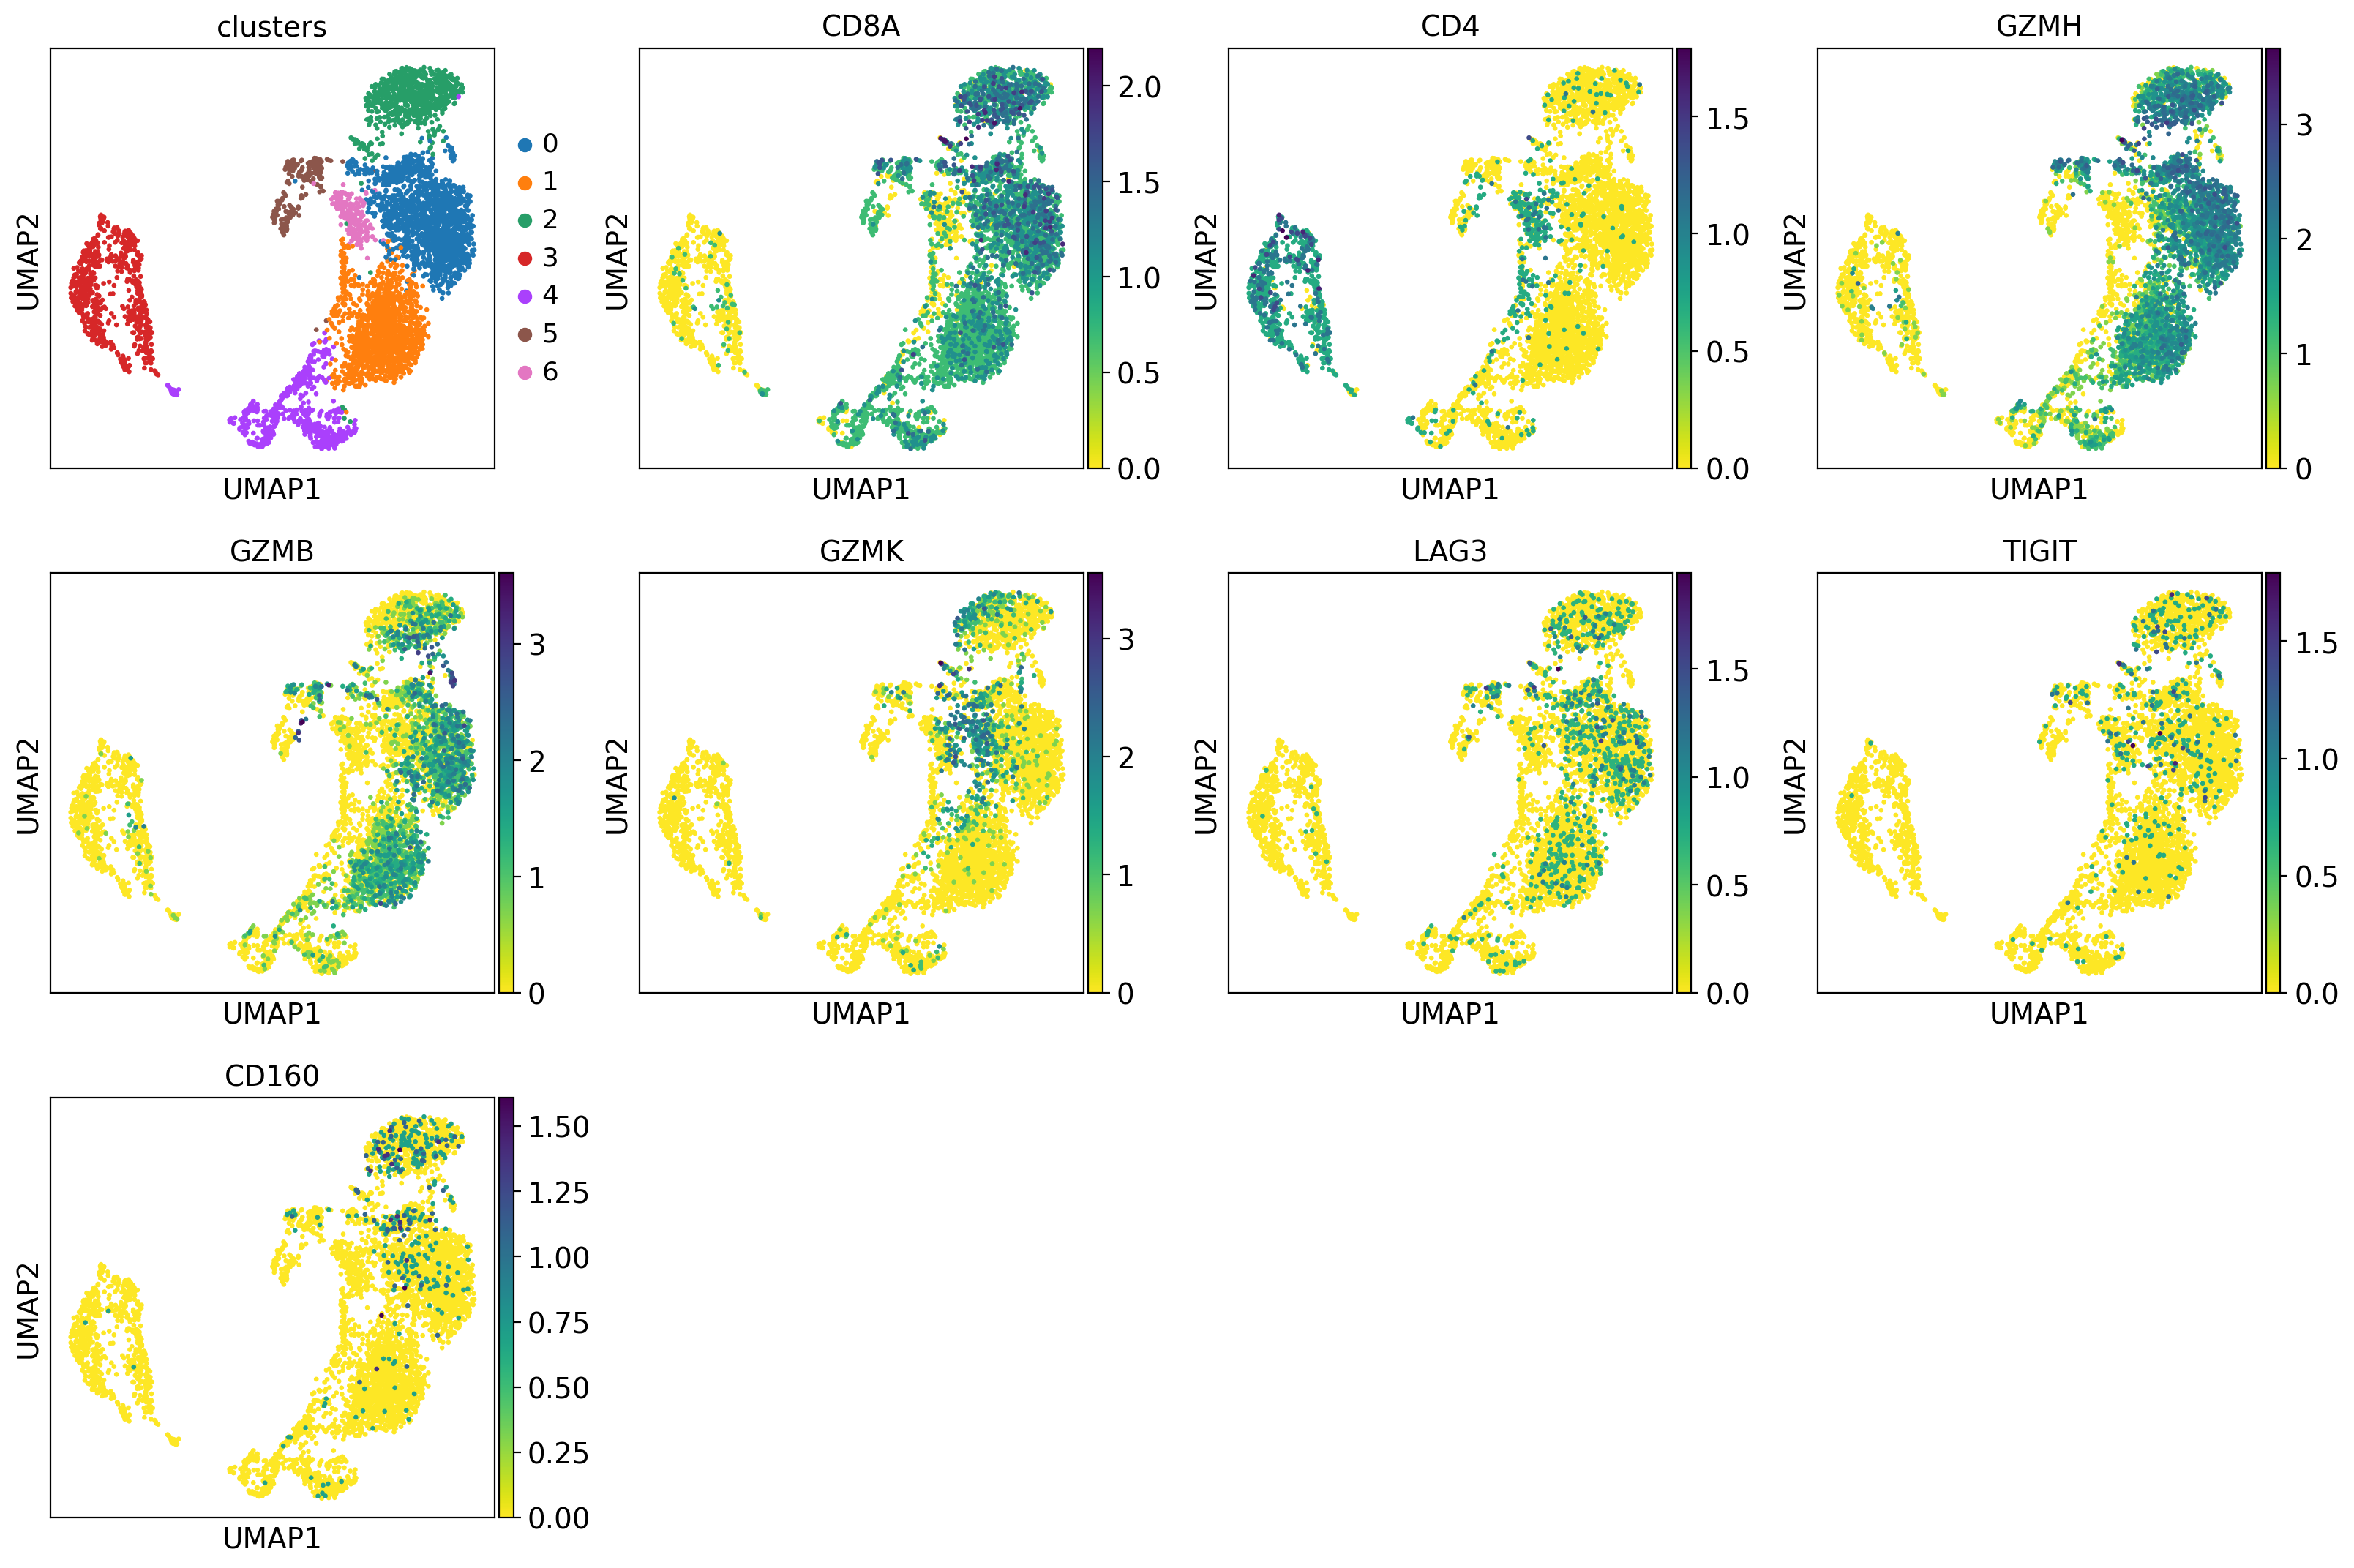

In [14]:
with rc_context({'figure.figsize': (4, 4)}):
  #sc.pl.pca( tcell_cll_anndata, color=['clusters', 'PDCD1', 'LAG3', 'CD160', 'ZAP70', 'CD4', 'CD8A'])
  #sc.pl.umap(tcell_cll_anndata, color=['clusters', 'CD8A', 'CD4', 'ZAP70', 'GZMH', 'GZMB', 'GZMK', 'LAG3', 'TIGIT', 'HAVCR2', 'CD160'])
  sc.pl.umap(tcell_cll_anndata, color=['clusters', 'CD8A', 'CD4', 'GZMH', 'GZMB', 'GZMK', 'LAG3', 'TIGIT', 'CD160'])

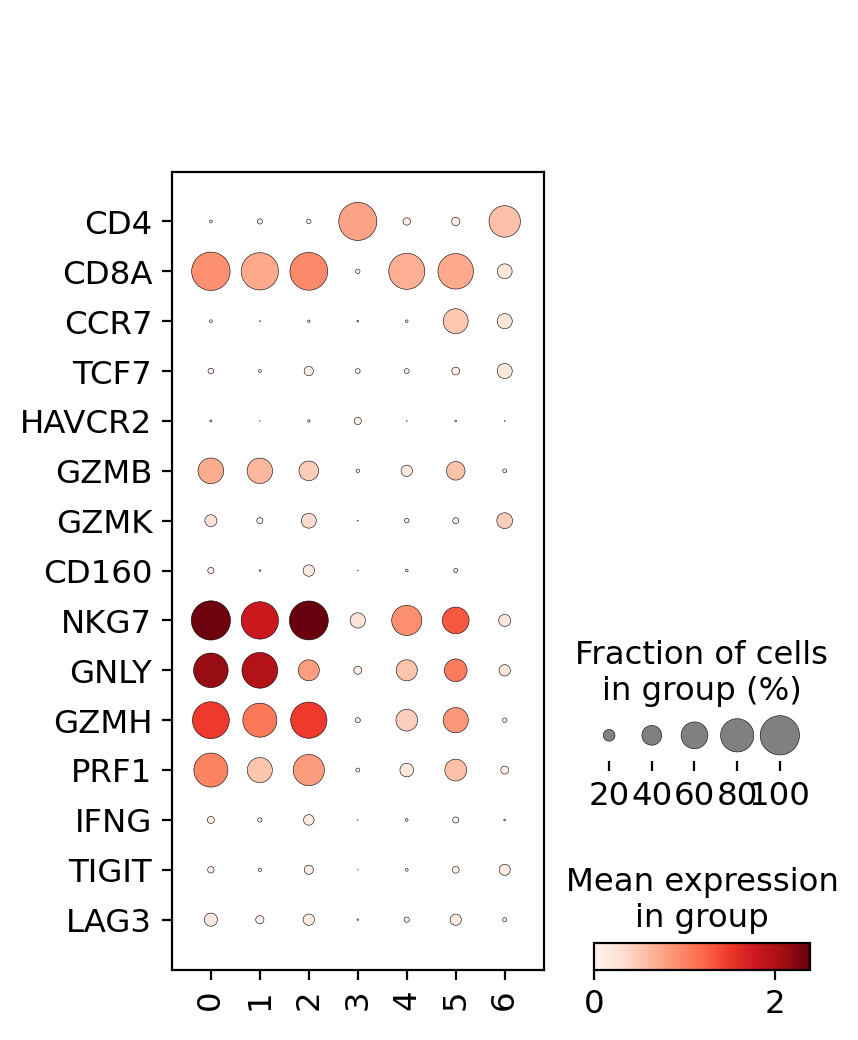

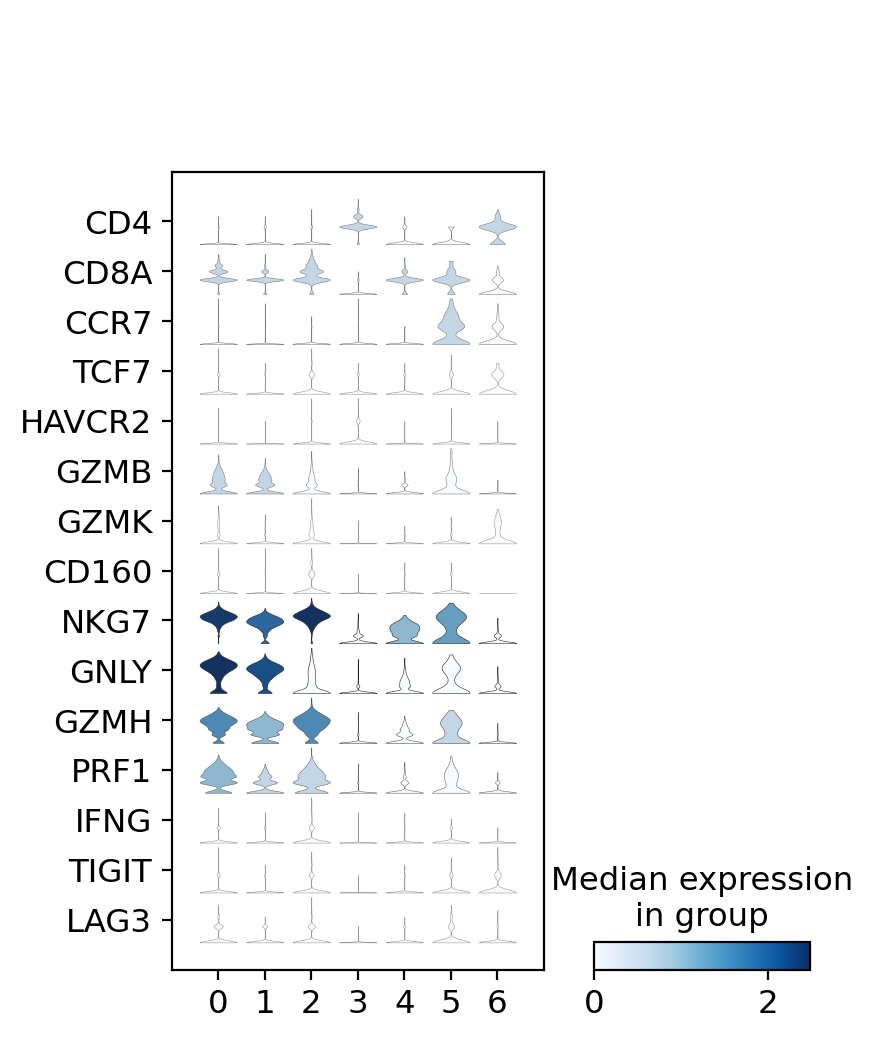

In [15]:
markers = ["CD4","CD8A","CCR7","TCF7","HAVCR2","GZMB","GZMK", 'CD160', 'NKG7', 'GNLY', 'GZMH', 'PRF1',"IFNG",'TIGIT', 'LAG3']

sc.pl.dotplot(tcell_cll_anndata, markers, groupby='clusters', swap_axes=True)
sc.pl.stacked_violin(tcell_cll_anndata, markers, groupby='clusters', swap_axes=True)

In [16]:
#quick test to see if clustering only by known markers made any sort of difference in cluster quality - clusters were of poor quality and not included in report
umap_reducer = umap.UMAP(random_state=456)
umap_markers = umap_reducer.fit_transform(tcell_cll_anndata[:, markers].X.toarray())
tcell_cll_anndata.obsm['umap_markers'] = umap_markers
sc.tl.louvain(tcell_cll_anndata, key_added='clusters', resolution=.6)

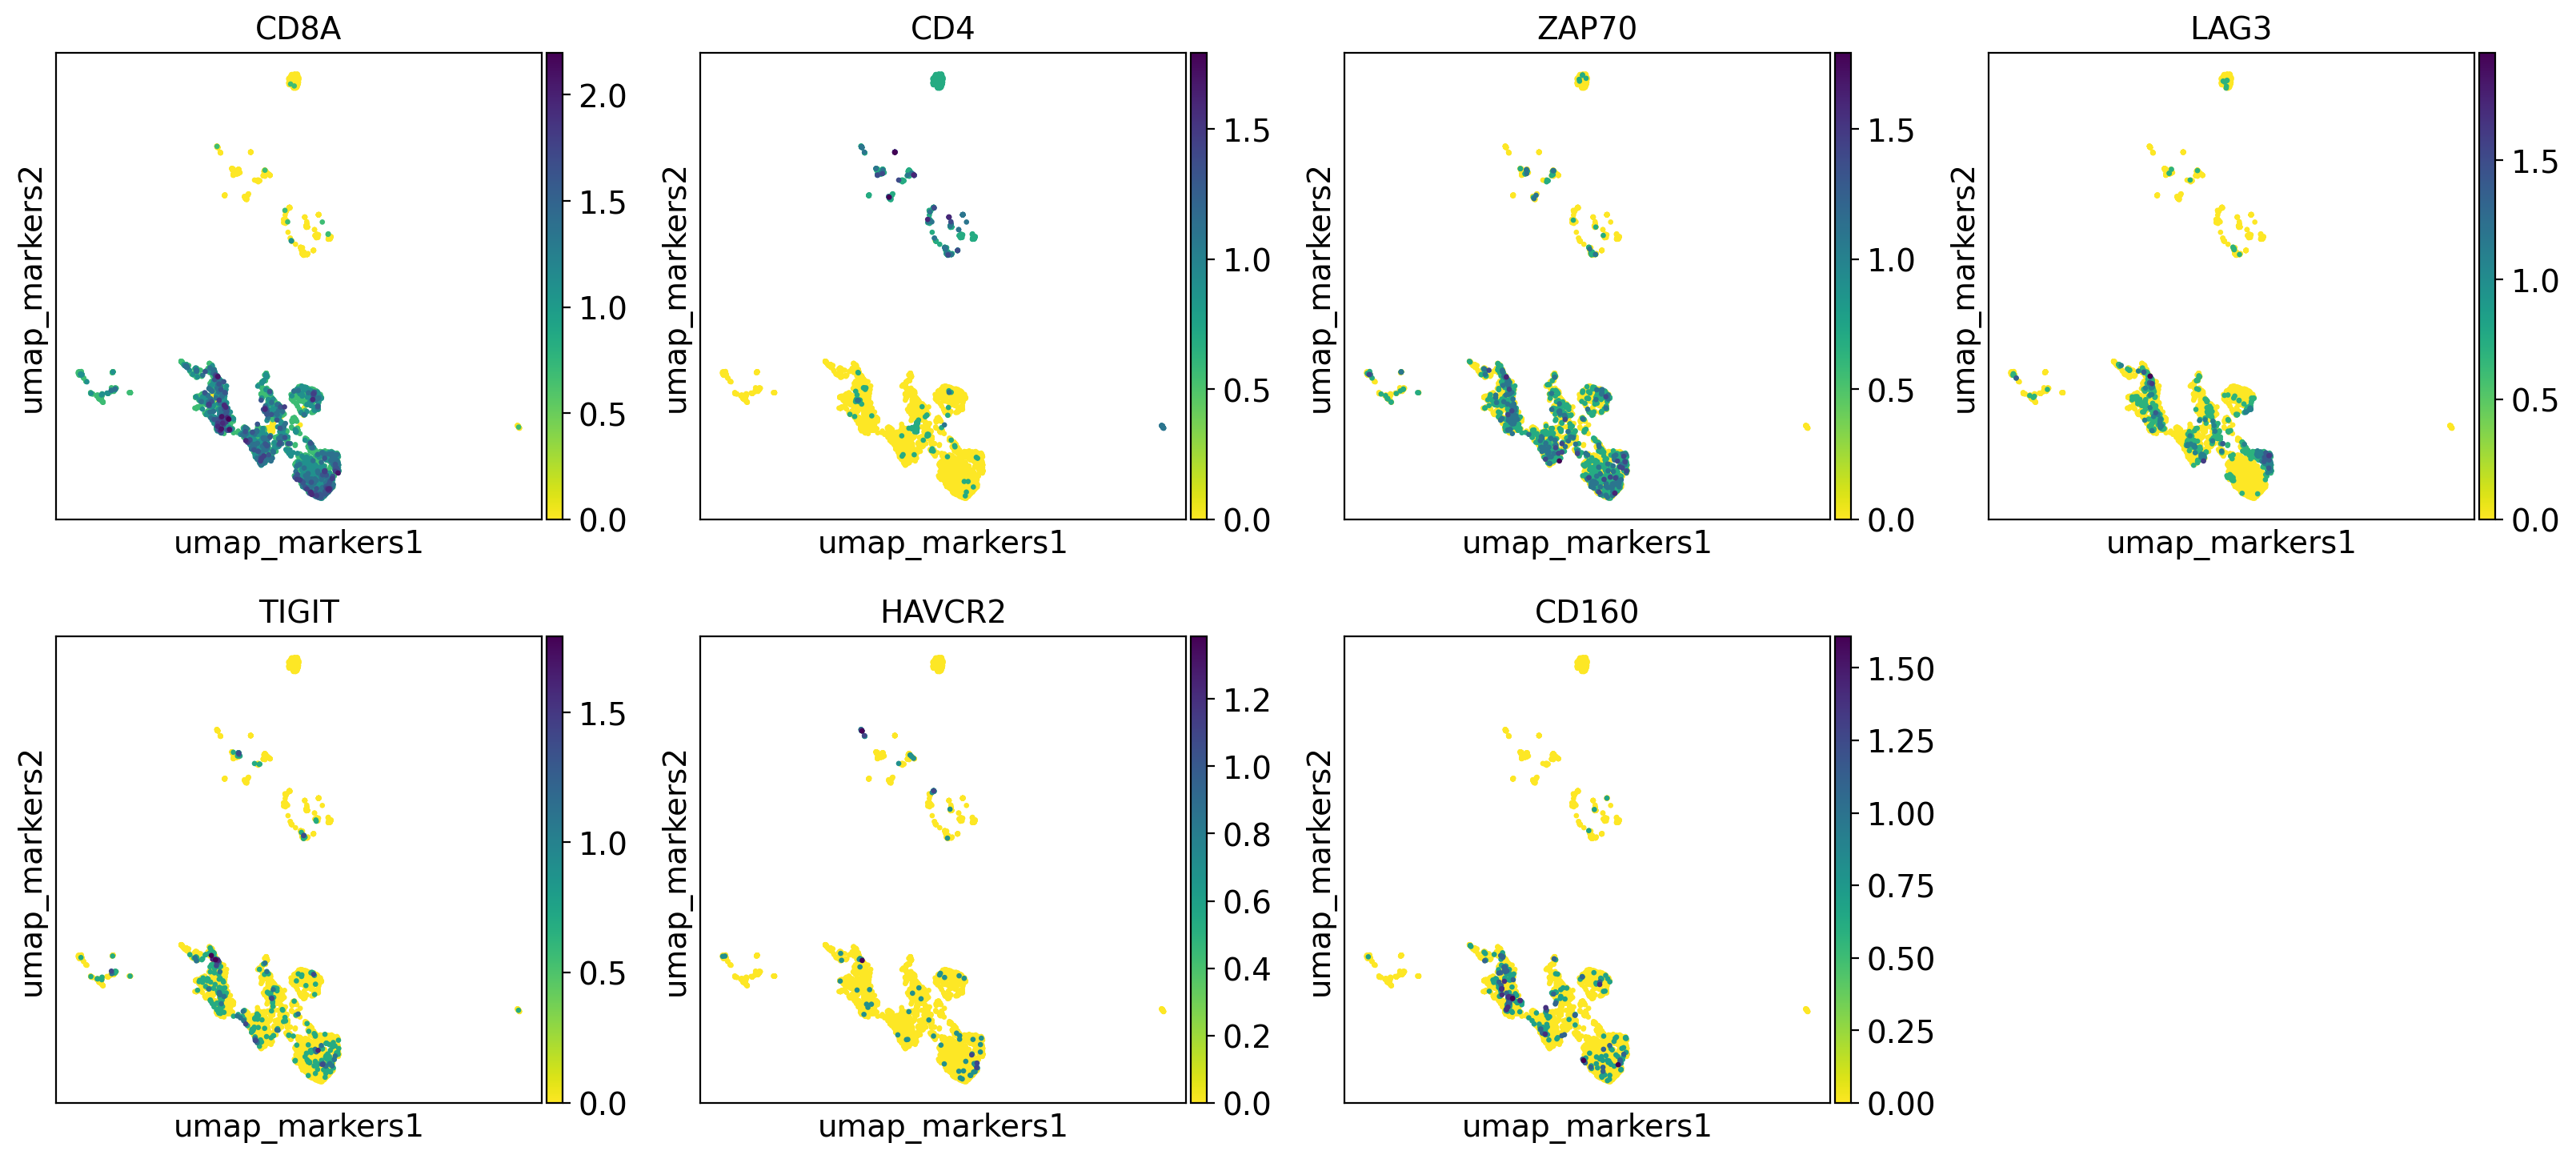

In [17]:
with rc_context({'figure.figsize': (4, 4)}):
  sc.pl.embedding(tcell_cll_anndata, basis='umap_markers', color=['CD8A', 'CD4', 'ZAP70', 'LAG3', 'TIGIT', 'HAVCR2', 'CD160'])

In [18]:
dense_gene_array = tcell_cll_anndata[:, tcell_cll_anndata.var.highly_variable].X.toarray()

In [19]:
print(np.sum(tcell_cll_anndata.var.highly_variable))

4096


In [20]:
dense_gene_array.shape

(5232, 4096)

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, Lambda, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [22]:
# standard autoencoder implementation
im_shape = (dense_gene_array.shape[1],)
input = Input(shape=(im_shape), name='input')
flatten_1 = Flatten()(input)
dense_1 = Dense(1028, activation='relu')(flatten_1)
dense_2 = Dense(128, activation='relu')(dense_1)
dropout_1 = Dropout(.1)(dense_2)
encoding = Dense(24, activation='relu', activity_regularizer=regularizers.l1(10e-5))(dropout_1)
dense_3 = Dense(128, activation='relu')(encoding)
dense_4 = Dense(1028, activation='relu')(dense_3)
output = Dense(dense_gene_array.shape[1], activation='sigmoid')(dense_4)

encoder = Model(inputs = input, outputs = encoding)
autoencoder = Model(inputs = input, outputs = output)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
# 60:20:20 split
x_train, x_test, y_train, y_test = train_test_split(dense_gene_array, dense_gene_array, test_size=0.4)
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test, test_size=0.5)

In [24]:
x_train.shape

(3139, 4096)

In [25]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_validate, x_validate),
                callbacks=[es])

Epoch 1/20
25/25 [==============================] - 7s 223ms/step - loss: 0.1349 - val_loss: 0.0971
Epoch 2/20
25/25 [==============================] - 5s 208ms/step - loss: 0.0922 - val_loss: 0.0872
Epoch 3/20
25/25 [==============================] - 8s 313ms/step - loss: 0.0843 - val_loss: 0.0789
Epoch 4/20
25/25 [==============================] - 12s 469ms/step - loss: 0.0784 - val_loss: 0.0753
Epoch 5/20
25/25 [==============================] - 9s 357ms/step - loss: 0.0753 - val_loss: 0.0740
Epoch 6/20
25/25 [==============================] - 9s 363ms/step - loss: 0.0747 - val_loss: 0.0736
Epoch 7/20
25/25 [==============================] - 11s 466ms/step - loss: 0.0745 - val_loss: 0.0735
Epoch 8/20
25/25 [==============================] - 11s 452ms/step - loss: 0.0739 - val_loss: 0.0729
Epoch 9/20
25/25 [==============================] - 11s 445ms/step - loss: 0.0735 - val_loss: 0.0727
Epoch 10/20
25/25 [==============================] - 10s 386ms/step - loss: 0.0733 - val_loss: 0

In [26]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print(scores)

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

0.07250497490167618


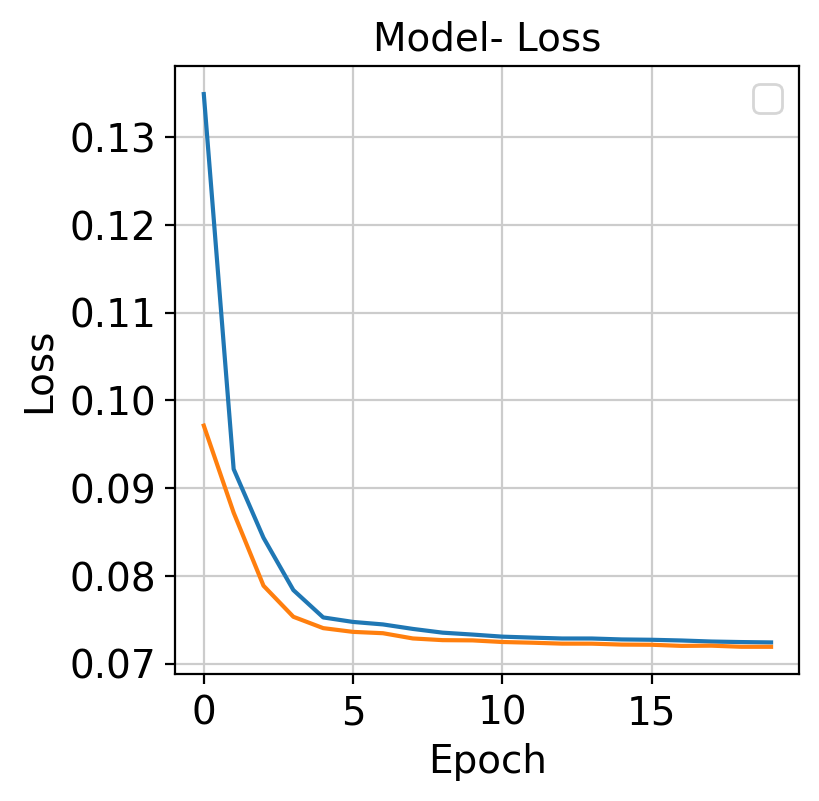

In [27]:
evaluate_model(history, x_test, x_test, autoencoder)

In [28]:
predictions = encoder.predict(dense_gene_array)

In [29]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [30]:
score_2 = []
range_values = range(1, 20)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(predictions)
    score_2.append(kmeans.inertia_)


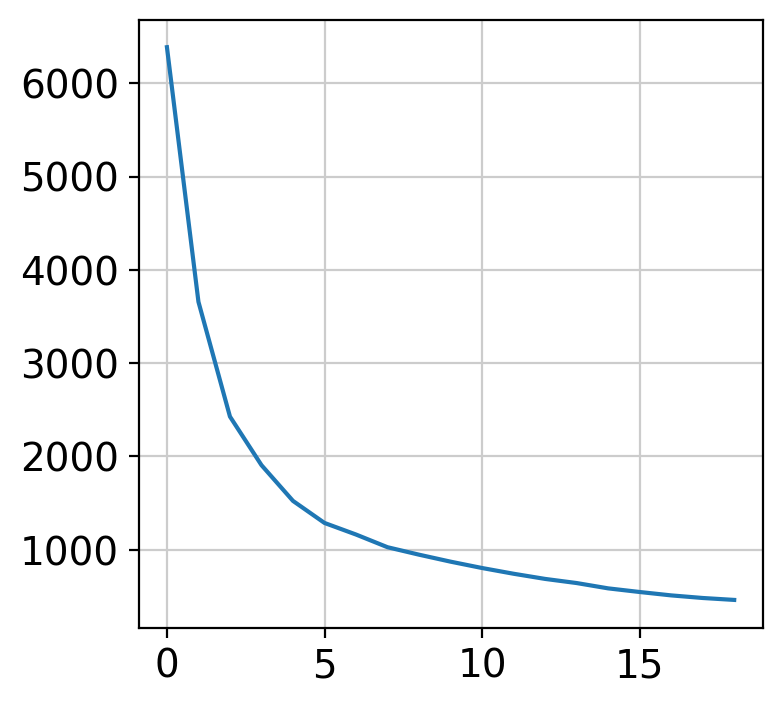

In [31]:
plt.plot(score_2)
plt.show()

In [32]:
tcell_cll_anndata.obsm['encoded'] = predictions
sc.pp.neighbors(tcell_cll_anndata, n_neighbors = 20, use_rep='encoded', key_added='encoded_neighbors')

In [33]:
#tcell_cll_anndata.obs['kmeans_encoded'] = labels.astype('str')
sc.tl.louvain(tcell_cll_anndata, resolution=.25, neighbors_key='encoded_neighbors', key_added='louvain_encoded')

In [34]:
pca_reducer = PCA(2)
pca_encoded = pca_reducer.fit_transform(predictions)
umap_reducer = umap.UMAP()
umap_encoded = umap_reducer.fit_transform(predictions)
tcell_cll_anndata.obsm['umap_encoded'] = umap_encoded

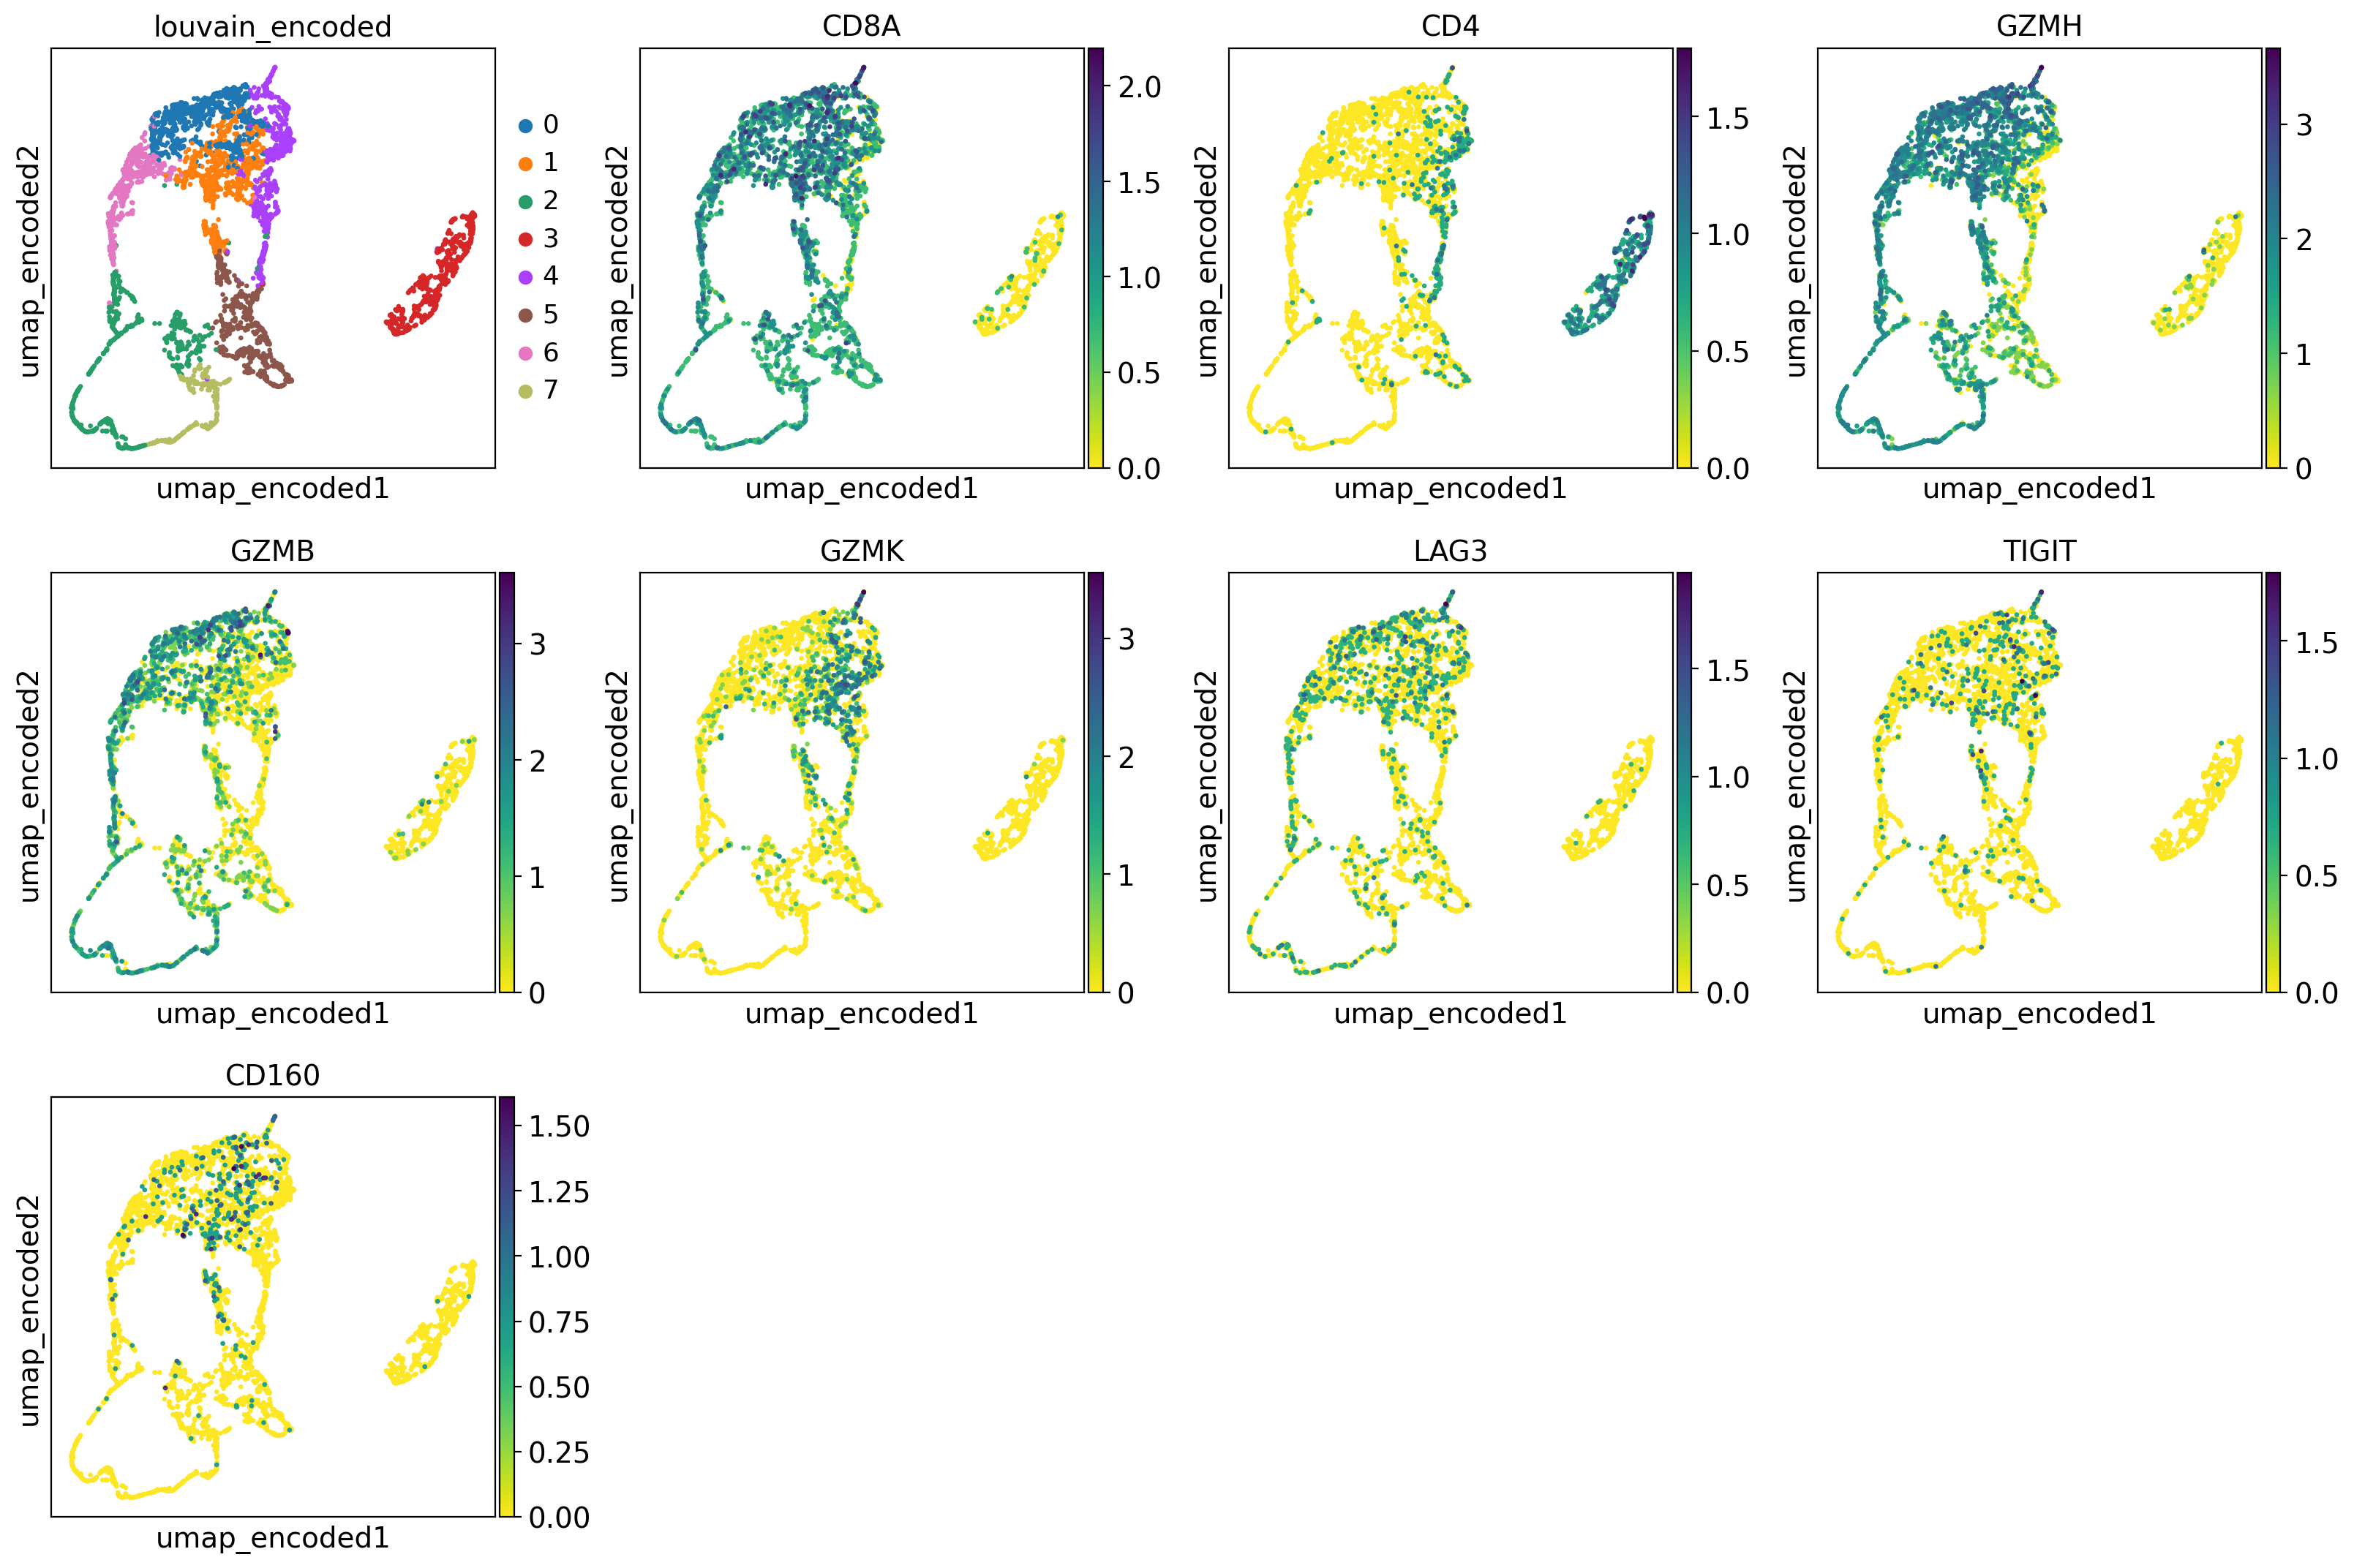

In [35]:
with rc_context({'figure.figsize': (4, 4)}):
  sc.pl.embedding(tcell_cll_anndata, basis='umap_encoded', color=['louvain_encoded', 'CD8A', 'CD4', 'GZMH', 'GZMB', 'GZMK', 'LAG3', 'TIGIT', 'CD160'])

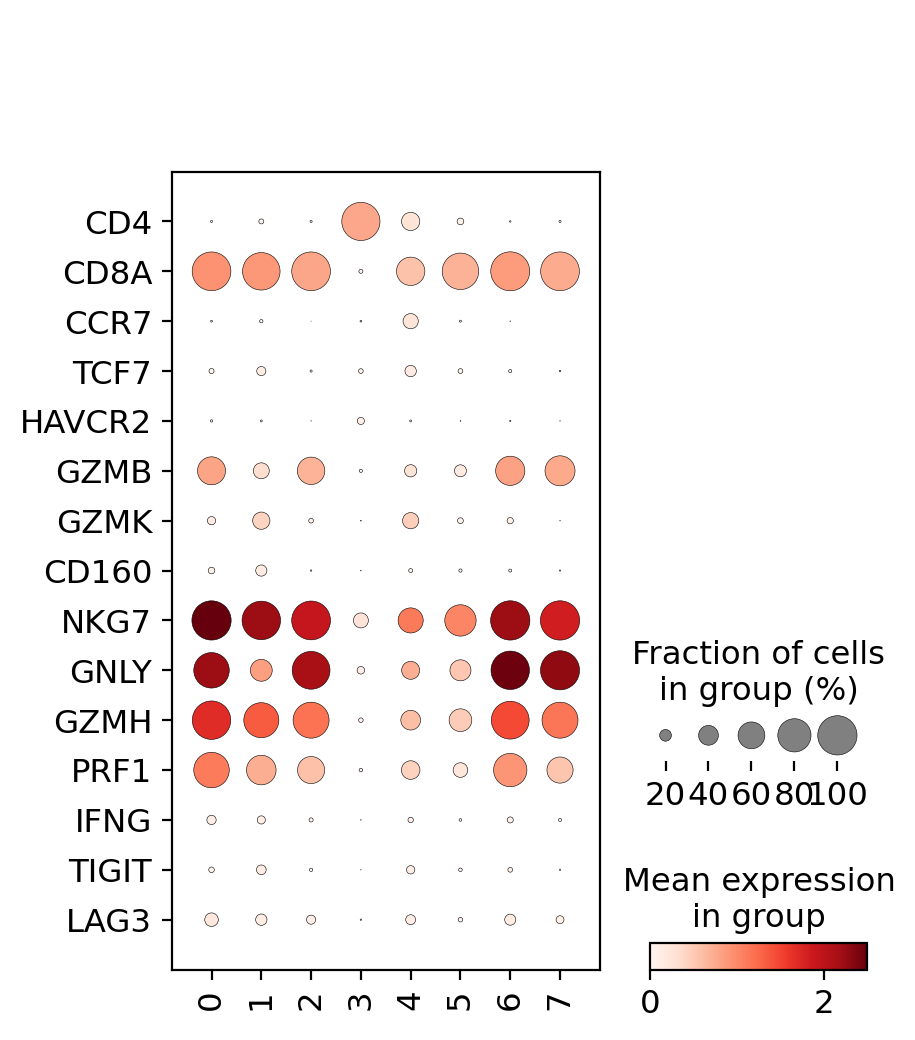

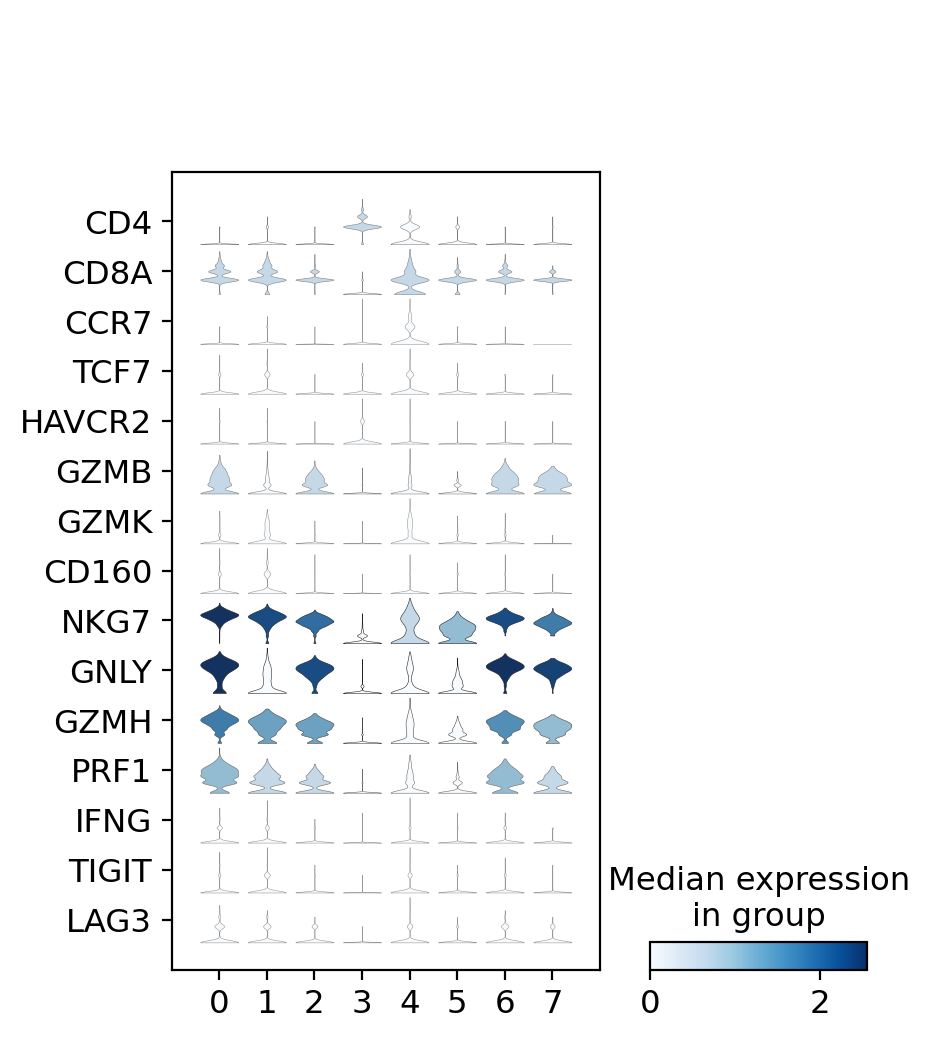

In [36]:
sc.pl.dotplot(tcell_cll_anndata, markers, groupby='louvain_encoded', swap_axes=True)
sc.pl.stacked_violin(tcell_cll_anndata, markers, groupby='louvain_encoded', swap_axes=True)

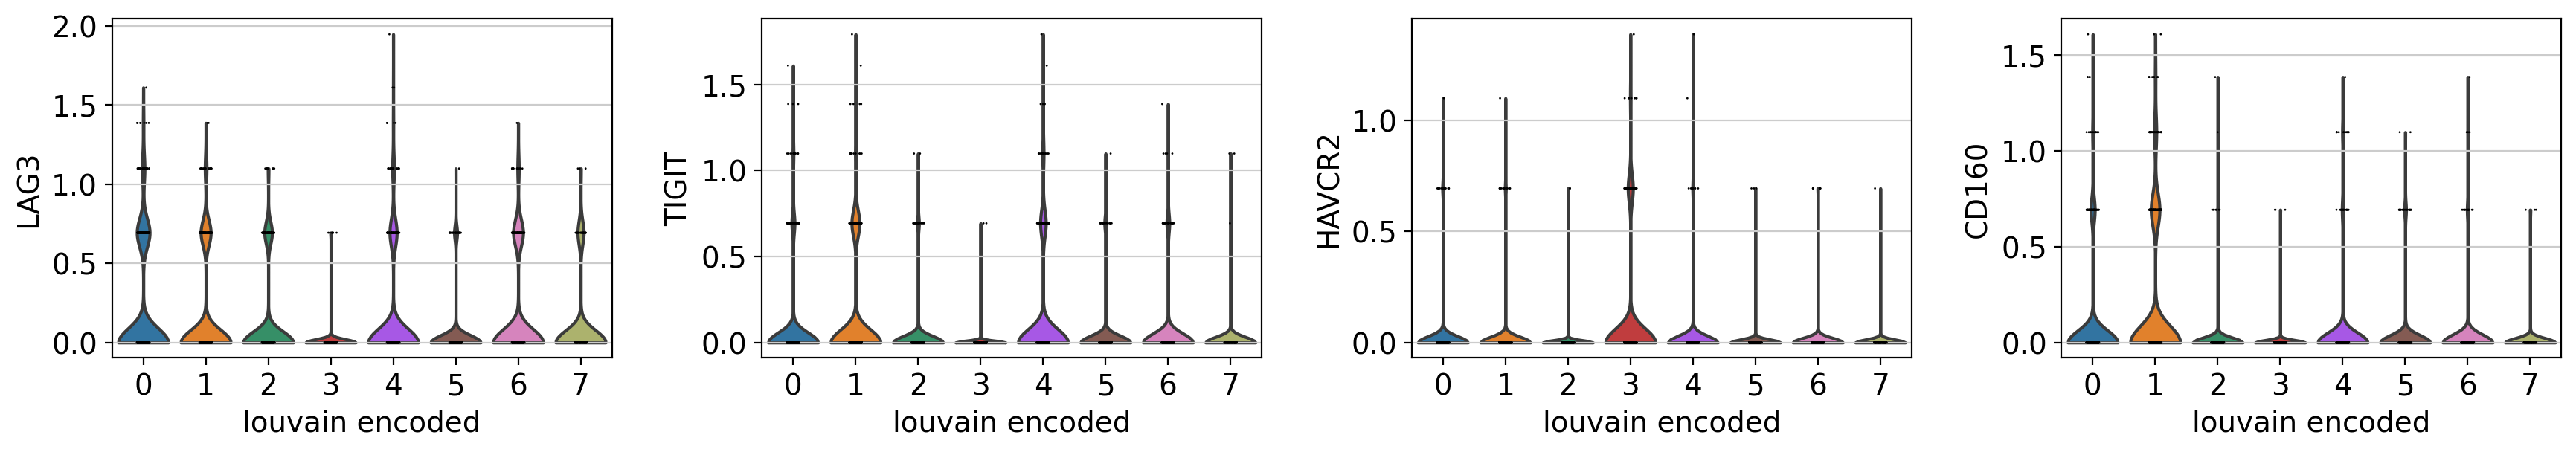

In [37]:
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(tcell_cll_anndata, ['LAG3', 'TIGIT', 'HAVCR2', 'CD160'], groupby='louvain_encoded' )

In [38]:
def Crop(start, end):
  def func(x):
    return x[:, start:end]
  return Lambda(func)

In [39]:
#genes to be passed through to code layer
marker_genes = np.array(['CD8A', 'CD4', 'LAG3'], dtype='str')
dense_gene_array_passthrough = np.concatenate((dense_gene_array, tcell_cll_anndata[:, marker_genes].X.toarray()), 1)

In [40]:
print(dense_gene_array_passthrough.shape)
print(dense_gene_array_passthrough.shape[1] - len(marker_genes))

(5232, 4099)
4096


In [41]:
#hyperparameters such as layer size and dropout rate chosen by hand
im_shape = (dense_gene_array_passthrough.shape[1],)
input = Input(shape=(im_shape), name='input')
flatten_1 = Flatten()(input)
genes   = Crop(0, dense_gene_array_passthrough.shape[1] - len(marker_genes))(flatten_1)
marker_layer = Crop(dense_gene_array_passthrough.shape[1] - len(marker_genes), dense_gene_array_passthrough.shape[1])(flatten_1)
dense_1 = Dense(1028, activation='relu')(genes)
dropout_1 = Dropout(.1)(dense_1)
dense_2 = Dense(128, activation='relu')(dropout_1)
dropout_2 = Dropout(.1)(dense_2)
code = Dense(44, activation='relu', activity_regularizer=regularizers.l1(10e-5))(dropout_2)
concat = Concatenate()([code, marker_layer])
encoding = Dense(20, activation='relu', activity_regularizer=regularizers.l1(10e-5))(concat)
dense_3 = Dense(128, activation='relu')(encoding)
dense_4 = Dense(1028, activation='relu')(dense_3)
output = Dense(dense_gene_array_passthrough.shape[1], activation='sigmoid')(dense_4)

encoder = Model(inputs = input, outputs = encoding)
autoencoder = Model(inputs = input, outputs = output)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
x_train, x_test, y_train, y_test = train_test_split(dense_gene_array_passthrough, dense_gene_array_passthrough, test_size=0.4)
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test, test_size=0.5)

In [43]:
print(autoencoder.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 4099)]       0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 4099)         0           ['input[0][0]']                  
                                                                                                  
 lambda (Lambda)                (None, 4096)         0           ['flatten_1[0][0]']              
                                                                                                  
 dense_6 (Dense)                (None, 1028)         4211716     ['lambda[0][0]']                 
                                                                                            

In [44]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_validate, x_validate),
                callbacks=[es])

Epoch 1/30
25/25 [==============================] - 5s 178ms/step - loss: 0.1489 - val_loss: 0.0958
Epoch 2/30
25/25 [==============================] - 4s 172ms/step - loss: 0.0910 - val_loss: 0.0818
Epoch 3/30
25/25 [==============================] - 4s 173ms/step - loss: 0.0816 - val_loss: 0.0771
Epoch 4/30
25/25 [==============================] - 4s 175ms/step - loss: 0.0778 - val_loss: 0.0738
Epoch 5/30
25/25 [==============================] - 5s 222ms/step - loss: 0.0757 - val_loss: 0.0734
Epoch 6/30
25/25 [==============================] - 4s 174ms/step - loss: 0.0751 - val_loss: 0.0727
Epoch 7/30
25/25 [==============================] - 4s 172ms/step - loss: 0.0745 - val_loss: 0.0721
Epoch 8/30
25/25 [==============================] - 4s 173ms/step - loss: 0.0740 - val_loss: 0.0718
Epoch 9/30
25/25 [==============================] - 4s 172ms/step - loss: 0.0737 - val_loss: 0.0716
Epoch 10/30
25/25 [==============================] - 4s 173ms/step - loss: 0.0735 - val_loss: 0.0715

0.07224491983652115


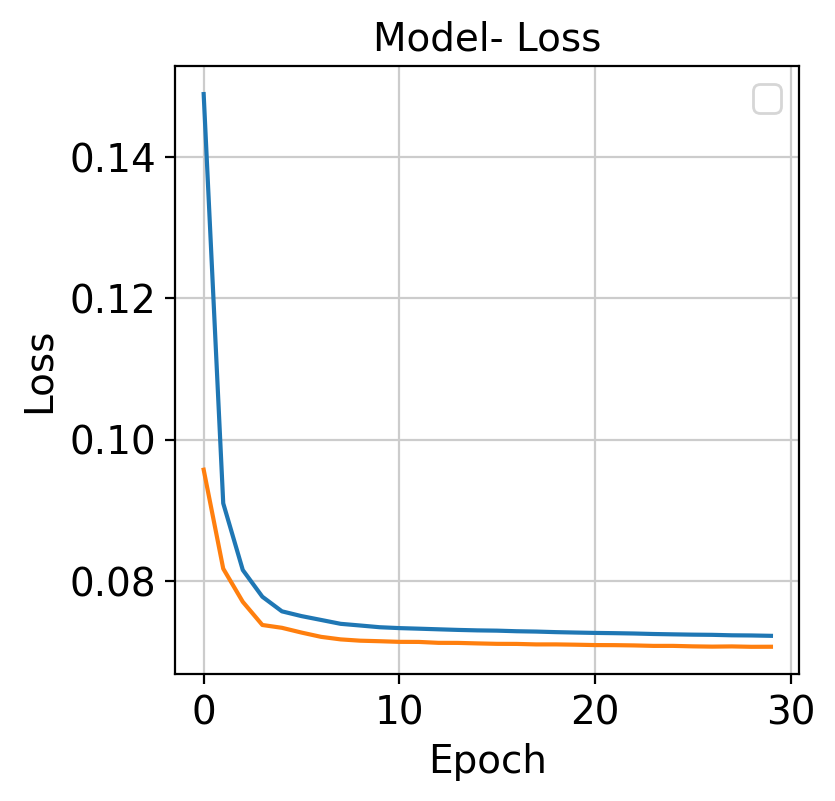

In [45]:
evaluate_model(history, x_test, x_test, autoencoder)

In [46]:
passthrough_predictions = encoder.predict(dense_gene_array_passthrough)
#print(passthrough_predictions)

In [47]:
#score_2 = []
#range_values = range(1, 20)
#for i in range_values:
#    kmeans = KMeans(n_clusters = i)
#    kmeans.fit(passthrough_predictions)
#    score_2.append(kmeans.inertia_)

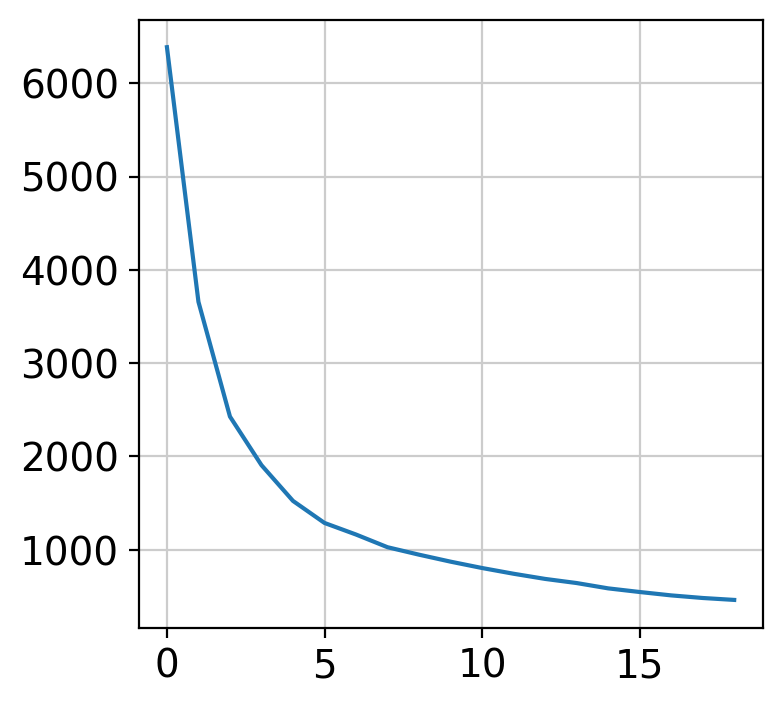

In [48]:
plt.plot(score_2)
plt.show()

In [49]:
#kmeans = KMeans(5)
#kmeans.fit(passthrough_predictions)
#labels = kmeans.labels_
tcell_cll_anndata.obsm['passthrough_encoded'] = passthrough_predictions
sc.pp.neighbors(tcell_cll_anndata, n_neighbors = 50, use_rep='passthrough_encoded', key_added='passthrough_encoded_neighbors')

In [50]:
#tcell_cll_anndata.obs['kmeans_passthrough_encoded'] = labels.astype('str')
#tcell_cll_anndata.obsm['passthrough_encoded'] = passthrough_predictions
sc.tl.louvain(tcell_cll_anndata, resolution=.25, neighbors_key='passthrough_encoded_neighbors', key_added='louvain_passthrough_encoded')

In [51]:
umap_reducer = umap.UMAP(random_state=456)
umap_passthrough_encoded = umap_reducer.fit_transform(passthrough_predictions)
tcell_cll_anndata.obsm['umap_passthrough_encoded'] = umap_passthrough_encoded

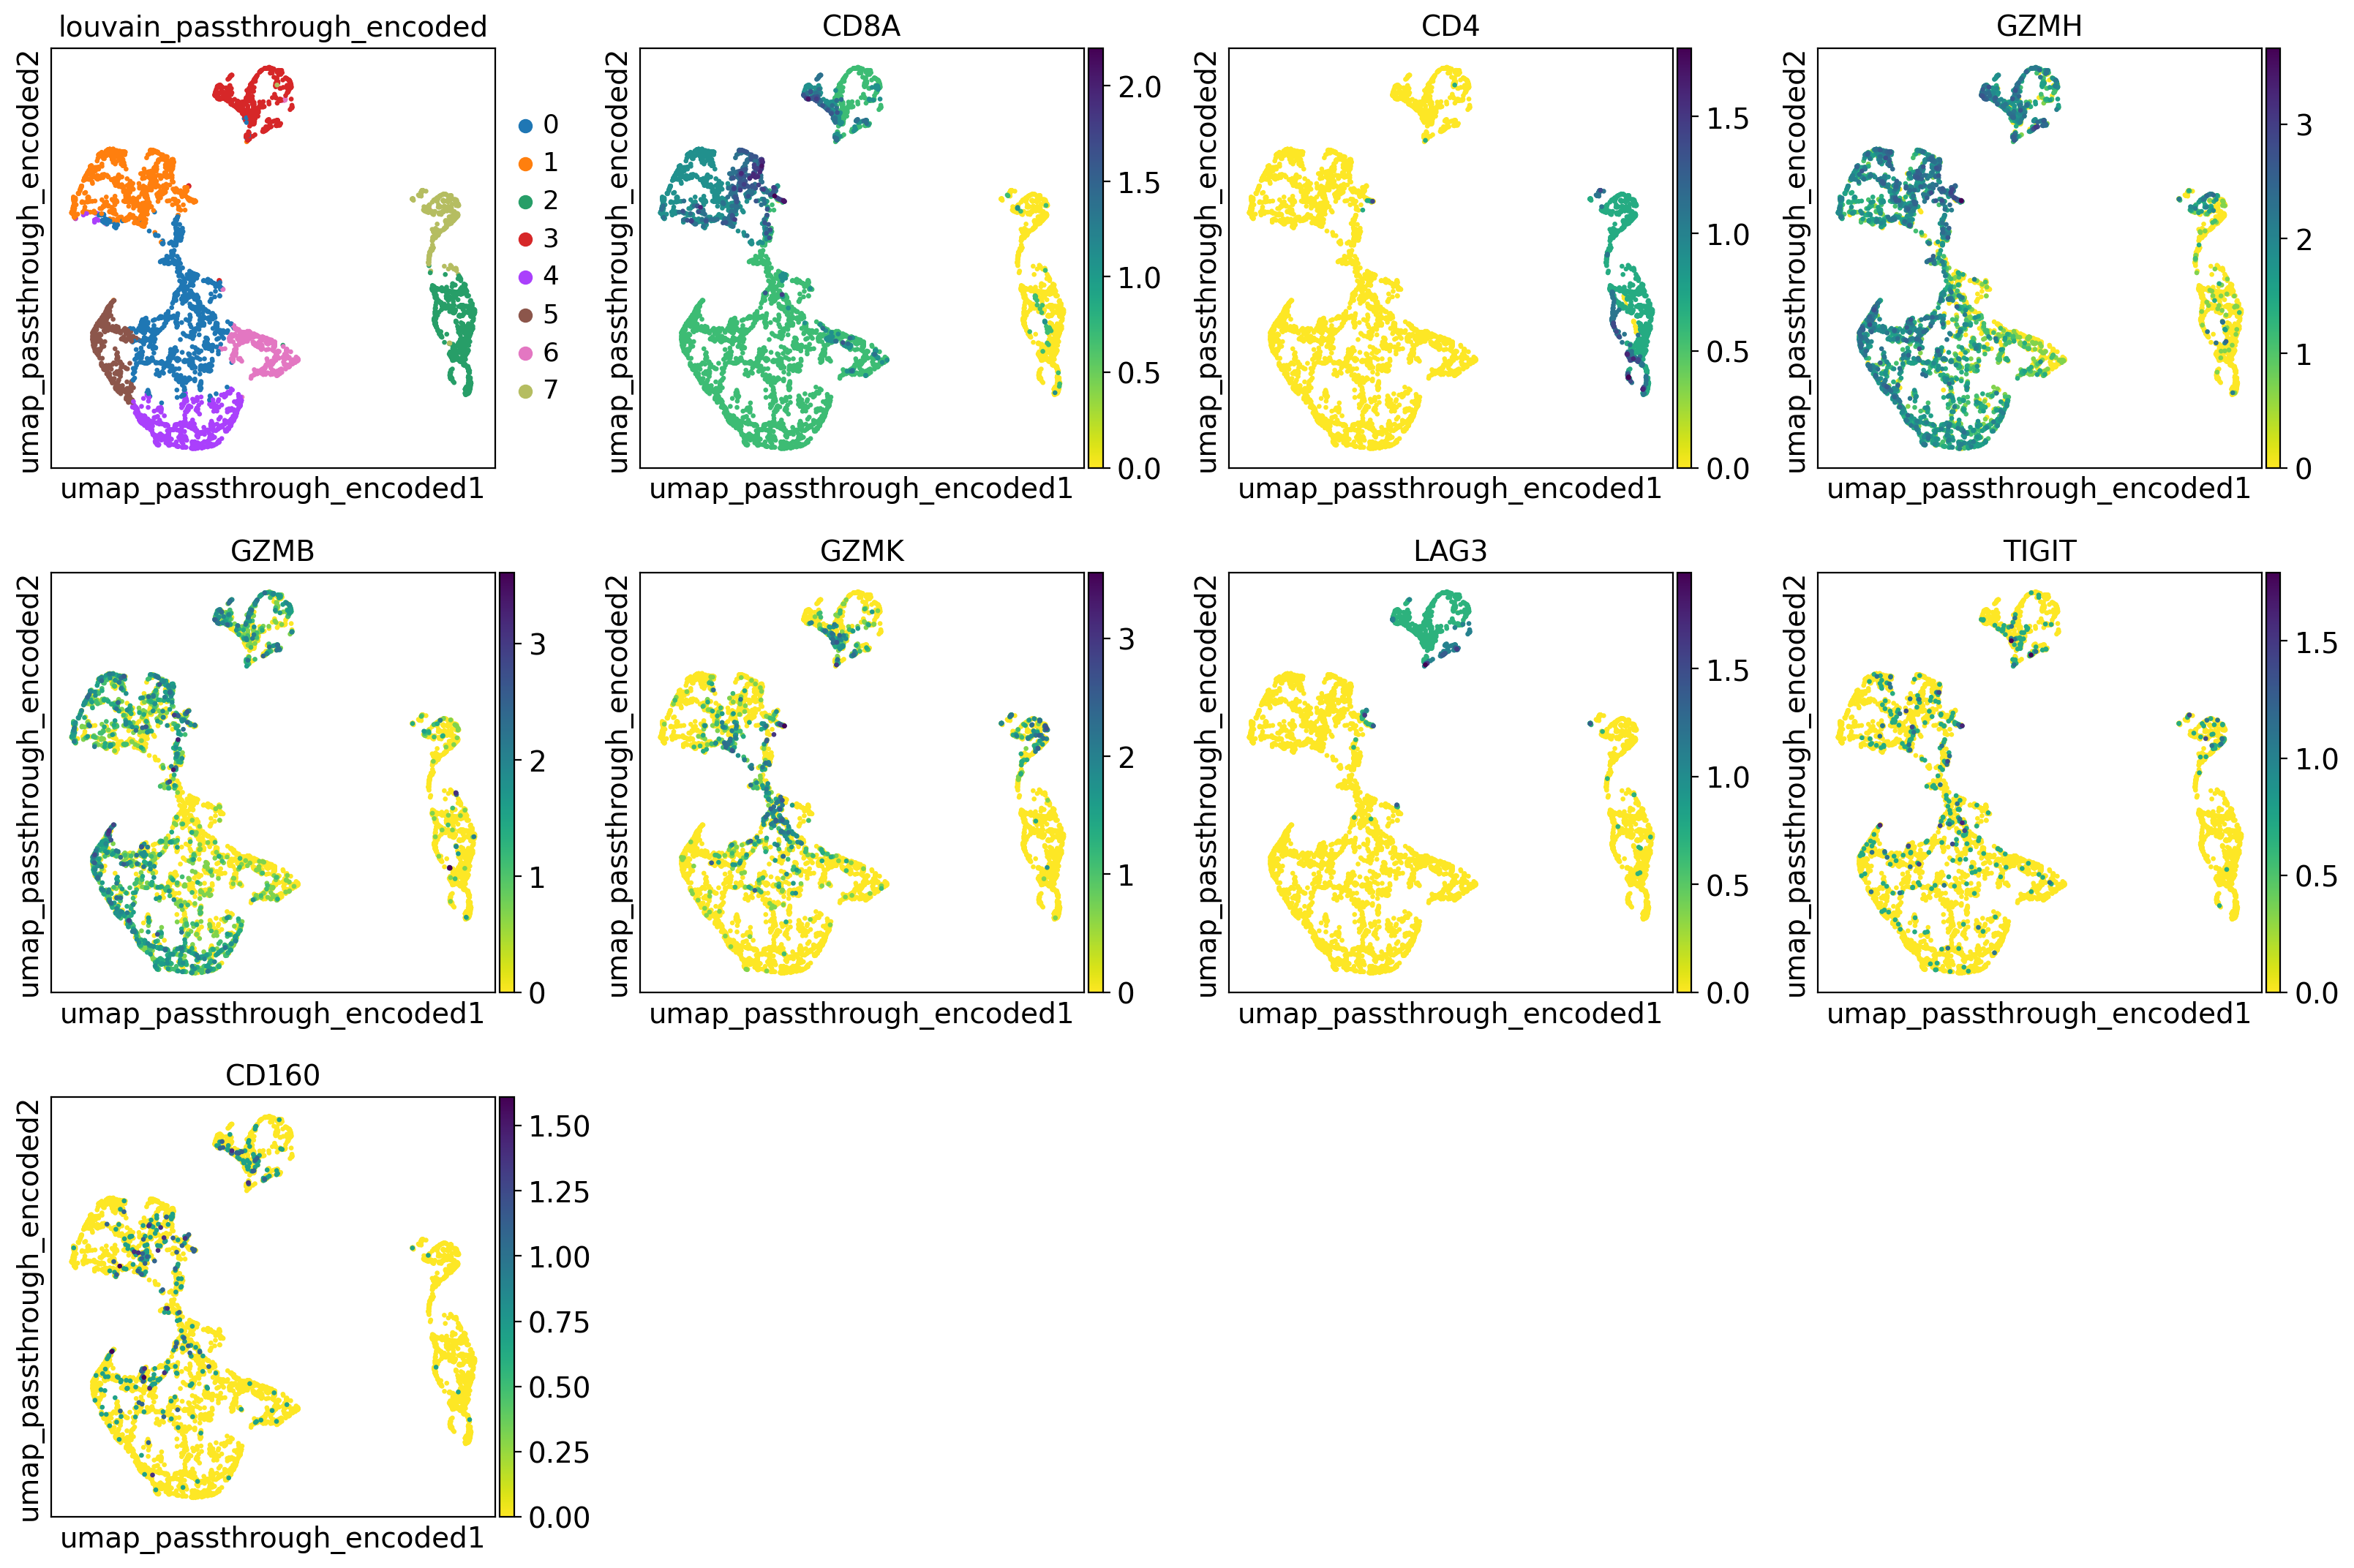

In [52]:
with rc_context({'figure.figsize': (4, 4)}):
  sc.pl.embedding(tcell_cll_anndata, basis='umap_passthrough_encoded', color=['louvain_passthrough_encoded', 'CD8A', 'CD4', 'GZMH', 'GZMB', 'GZMK', 'LAG3', 'TIGIT', 'CD160'])

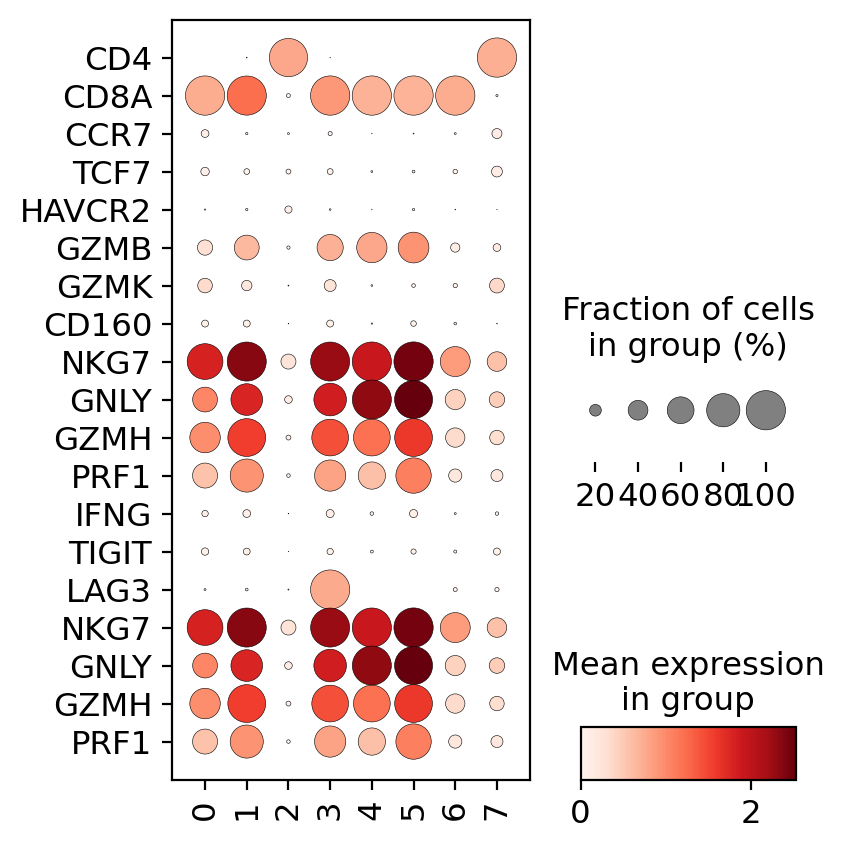

In [53]:
sc.pl.dotplot(tcell_cll_anndata, markers + ['NKG7', 'GNLY', 'GZMH', 'PRF1'], groupby='louvain_passthrough_encoded', figsize=(4,5), swap_axes=True)

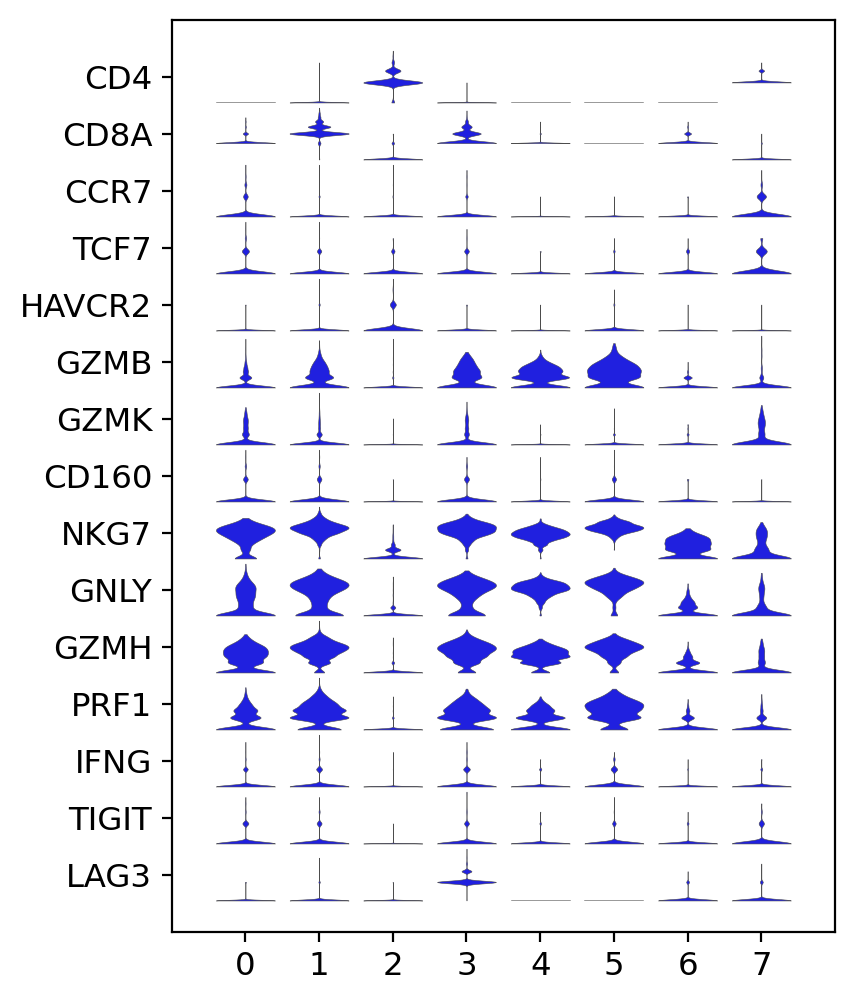

In [54]:
sc.pl.stacked_violin(tcell_cll_anndata, markers, groupby='louvain_passthrough_encoded', figsize=(6,6), row_palette='blue', swap_axes=True)

In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.tl.rank_genes_groups(tcell_cll_anndata, groupby='louvain_passthrough_encoded')
sc.tl.dendrogram(tcell_cll_anndata, groupby='louvain_encoded')
sc.tl.dendrogram(tcell_cll_anndata, groupby='louvain_passthrough_encoded')
sc.tl.dendrogram(tcell_cll_anndata, groupby='clusters')

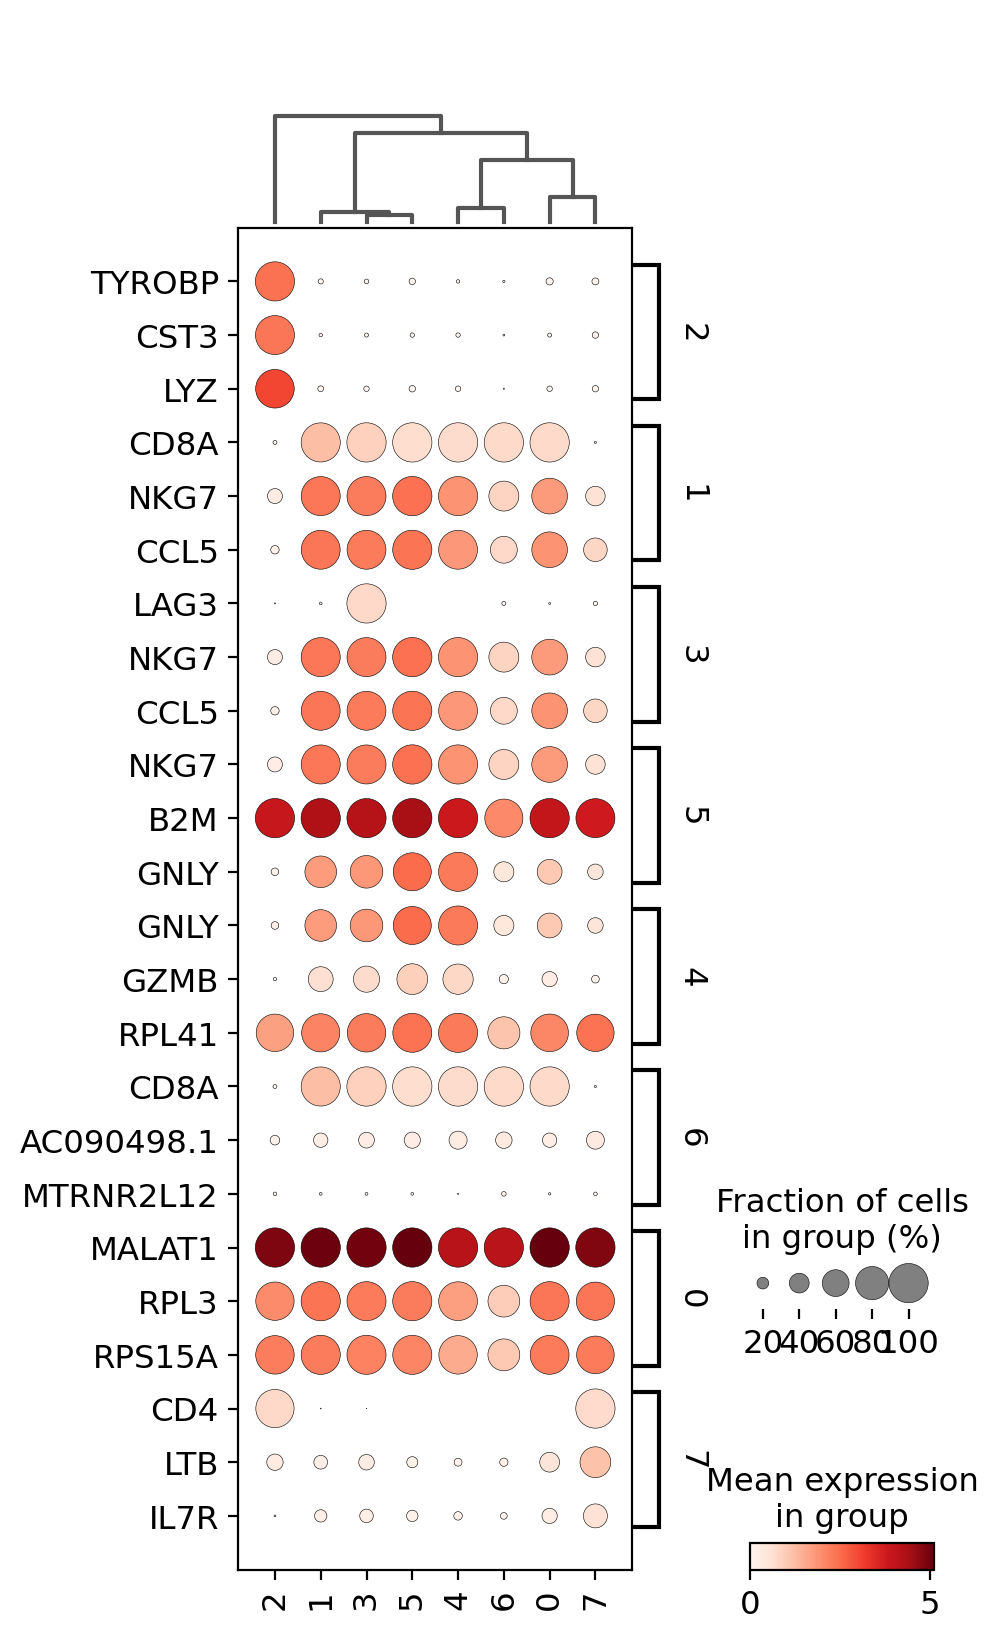

In [56]:
sc.pl.rank_genes_groups_dotplot(tcell_cll_anndata, groupby='louvain_passthrough_encoded', n_genes=3, swap_axes=True)

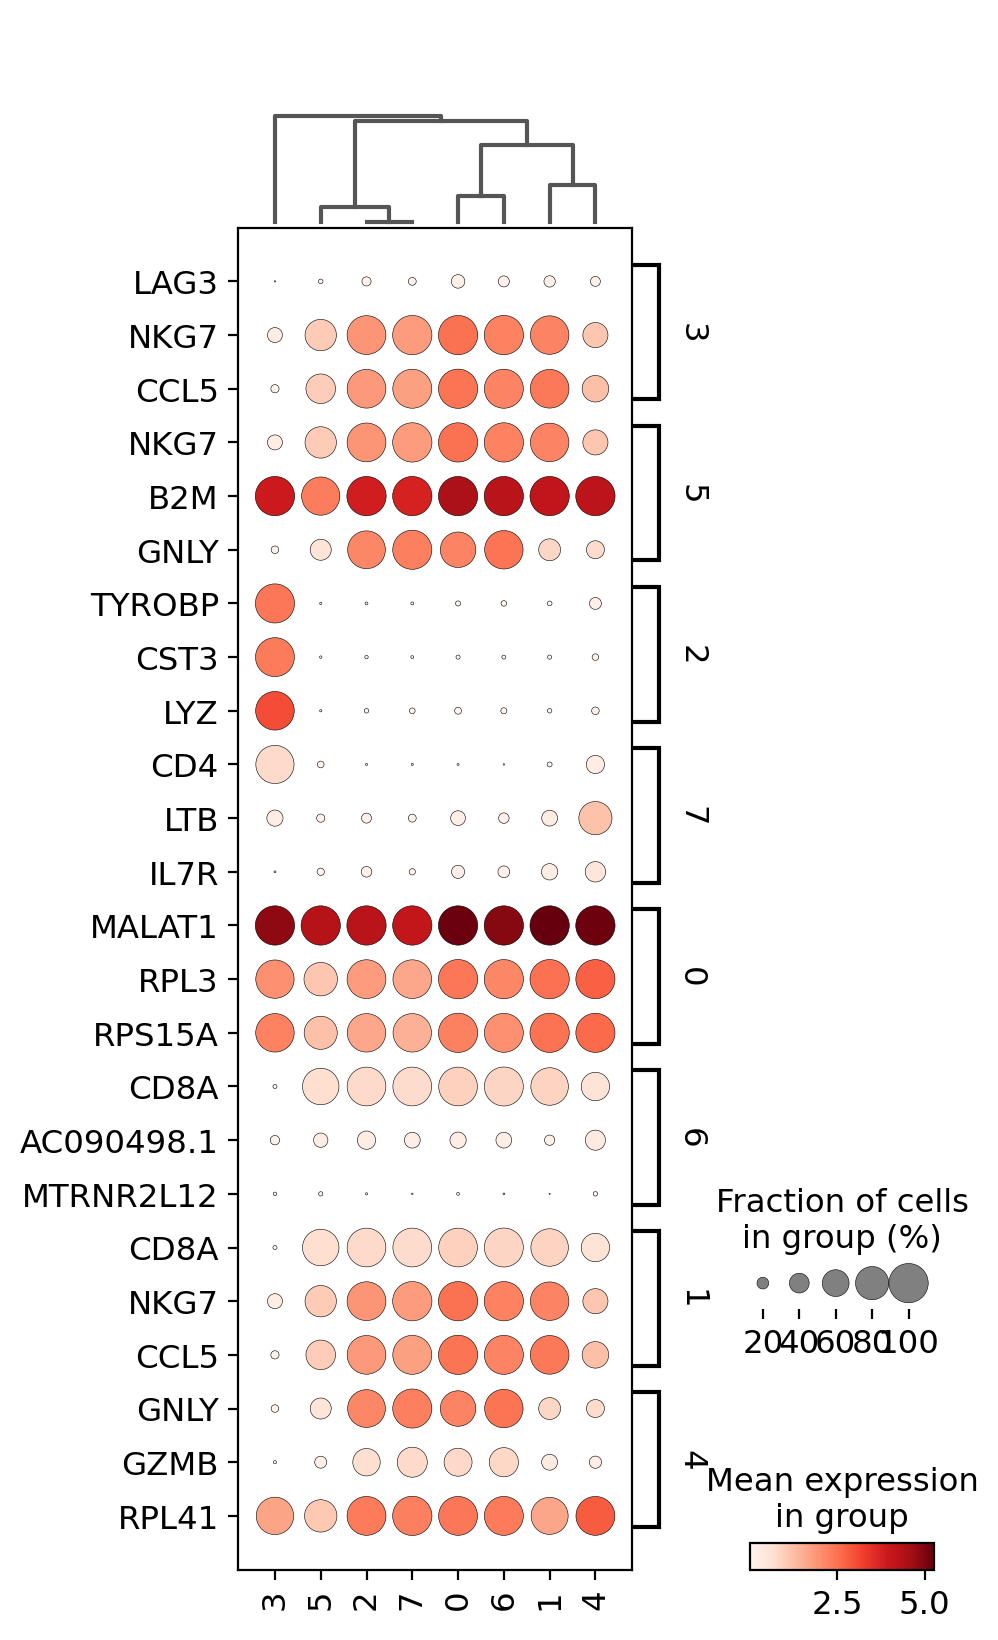

In [57]:
sc.pl.rank_genes_groups_dotplot(tcell_cll_anndata, groupby='louvain_encoded', n_genes=3, swap_axes=True)

categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


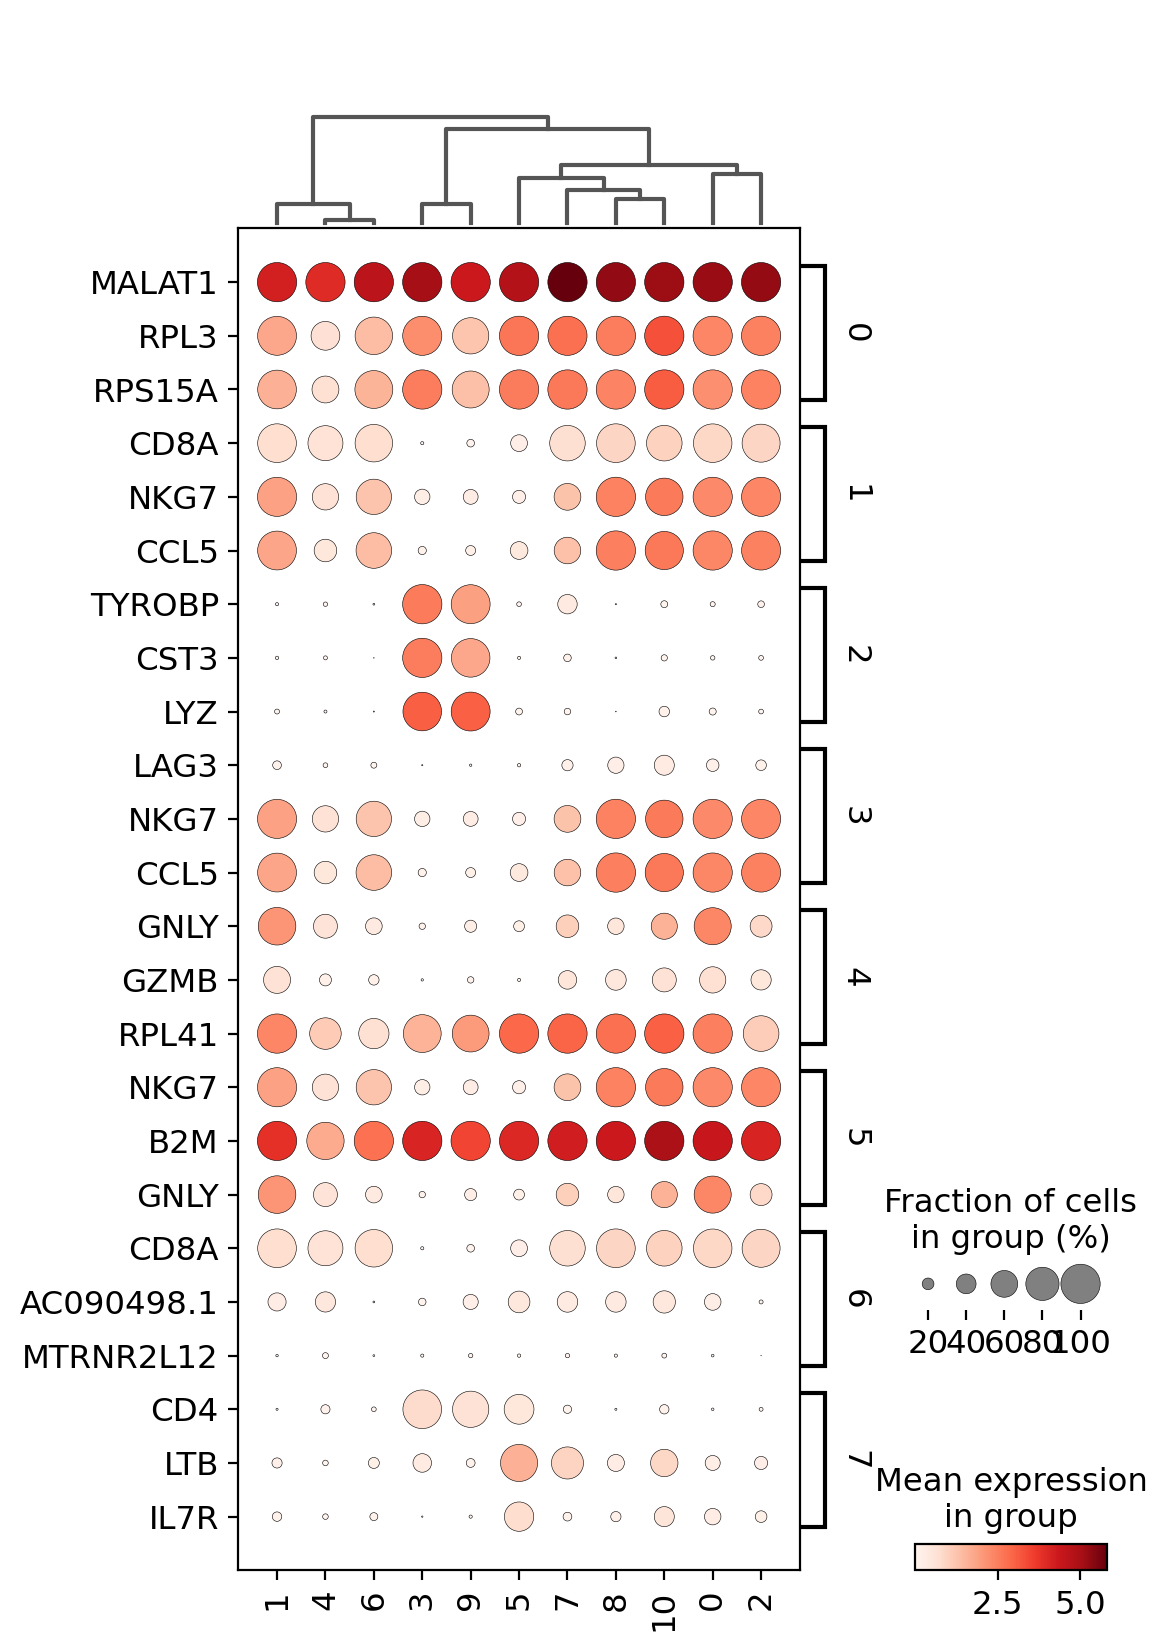

In [59]:
sc.pl.rank_genes_groups_dotplot(tcell_cll_anndata, groupby='clusters', n_genes=3, swap_axes=True)